In [1]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/generative_adversarial_network/main.py#L34-L50
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets 
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))    
])
mnist = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=64, shuffle=True)

In [3]:
# Discriminator
D = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# Generator
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Tanh()
)

if torch.cuda.is_available():
    D.cuda()
    G.cuda()

In [4]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

In [5]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [6]:
def gen_fake_images(N, generator_model):
    z = to_var(torch.randn(N, 64))
    return generator_model(z)

d_losses, g_losses = [], []
d_xs, d_g_xs = [], [] # D(x), D(G(x))
for epoch in range(100):
    for i, (images, _) in enumerate(data_loader):
        batch_size = images.size(0)
        images = to_var(images.view(batch_size, -1))
        
        real_labels = to_var(torch.ones(batch_size))
        fake_labels = to_var(torch.zeros(batch_size))
        
        # train D
        outputs = D(images)
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs
        
        fake_images = gen_fake_images(batch_size, G)
        outputs = D(fake_images)
        d_loss_fake = loss_fn(outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss.data[0])
        fake_score = outputs
        
        D.zero_grad()
        G.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # train G
        fake_images = gen_fake_images(batch_size, G)
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels) # try to deceive the Discriminator
        g_losses.append(g_loss.data[0])
        
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        d_xs.append(real_score.data.mean())
        d_g_xs.append(fake_score.data.mean())
        if (i+1) % 300 == 0:
            print('Epoch {:d}, Step {:.1f}%, d_loss: {:.4f}, g_loss: {:.4f}'.format(
                epoch+1, 100*i/len(data_loader), d_loss.data[0], g_loss.data[0]
            ))
            # D(x)   : probability of x is real training data
            # G(x)   : fake images generated by G
            # D(G(x)): probability which D think input data is real training data
            #          If this value is high, D is deceived by G. This is bad for D but good for G
            print('D(x) {:.4f}, D(G(x)) {:.4f}'.format(real_score.data.mean(), fake_score.data.mean()))
    
    # epoch end
    # save real images
    if epoch == 0:
        images = images.view(images.size(0), 1, 28, 28) # (batch, ch, w, h)
        save_image(denorm(images.data), './data/real_images.png')
    # save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images.data), './data/fake_images-%d.png' % (epoch+1))

/home/jonki/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 1, Step 31.9%, d_loss: 0.0803, g_loss: 4.4658
D(x) 0.9973, D(G(x)) 0.0704
Epoch 1, Step 63.9%, d_loss: 0.0161, g_loss: 5.4522
D(x) 0.9943, D(G(x)) 0.0098
Epoch 1, Step 95.8%, d_loss: 0.9380, g_loss: 3.1549
D(x) 0.7144, D(G(x)) 0.3027


/home/jonki/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 2, Step 31.9%, d_loss: 0.1876, g_loss: 4.7479
D(x) 0.9418, D(G(x)) 0.0931
Epoch 2, Step 63.9%, d_loss: 0.3871, g_loss: 2.4719
D(x) 0.8789, D(G(x)) 0.1839
Epoch 2, Step 95.8%, d_loss: 1.7090, g_loss: 1.3720
D(x) 0.6179, D(G(x)) 0.5754
Epoch 3, Step 31.9%, d_loss: 0.7056, g_loss: 2.4919
D(x) 0.7688, D(G(x)) 0.1966
Epoch 3, Step 63.9%, d_loss: 0.7001, g_loss: 3.4059
D(x) 0.7977, D(G(x)) 0.2185
Epoch 3, Step 95.8%, d_loss: 1.9287, g_loss: 1.4909
D(x) 0.6562, D(G(x)) 0.4137
Epoch 4, Step 31.9%, d_loss: 0.9844, g_loss: 1.6722
D(x) 0.8514, D(G(x)) 0.4859
Epoch 4, Step 63.9%, d_loss: 1.3330, g_loss: 1.8423
D(x) 0.6338, D(G(x)) 0.3292
Epoch 4, Step 95.8%, d_loss: 2.1812, g_loss: 1.4448
D(x) 0.4819, D(G(x)) 0.5137
Epoch 5, Step 31.9%, d_loss: 1.1706, g_loss: 1.4245
D(x) 0.5418, D(G(x)) 0.2796
Epoch 5, Step 63.9%, d_loss: 0.7772, g_loss: 2.1118
D(x) 0.7383, D(G(x)) 0.2536
Epoch 5, Step 95.8%, d_loss: 1.3946, g_loss: 1.2343
D(x) 0.5139, D(G(x)) 0.3881
Epoch 6, Step 31.9%, d_loss: 0.7153, g_l

Epoch 36, Step 31.9%, d_loss: 1.0153, g_loss: 1.9557
D(x) 0.6120, D(G(x)) 0.2516
Epoch 36, Step 63.9%, d_loss: 0.8220, g_loss: 1.8111
D(x) 0.7482, D(G(x)) 0.3047
Epoch 36, Step 95.8%, d_loss: 0.8884, g_loss: 1.5425
D(x) 0.7166, D(G(x)) 0.3313
Epoch 37, Step 31.9%, d_loss: 0.8351, g_loss: 1.4636
D(x) 0.7335, D(G(x)) 0.3099
Epoch 37, Step 63.9%, d_loss: 0.7871, g_loss: 2.0746
D(x) 0.7307, D(G(x)) 0.2836
Epoch 37, Step 95.8%, d_loss: 0.8419, g_loss: 1.5225
D(x) 0.7944, D(G(x)) 0.3722
Epoch 38, Step 31.9%, d_loss: 1.0504, g_loss: 1.0123
D(x) 0.7761, D(G(x)) 0.4093
Epoch 38, Step 63.9%, d_loss: 0.8176, g_loss: 1.7944
D(x) 0.7068, D(G(x)) 0.2715
Epoch 38, Step 95.8%, d_loss: 0.8883, g_loss: 1.7109
D(x) 0.7788, D(G(x)) 0.3602
Epoch 39, Step 31.9%, d_loss: 0.7042, g_loss: 1.6143
D(x) 0.7282, D(G(x)) 0.2334
Epoch 39, Step 63.9%, d_loss: 0.8285, g_loss: 1.4764
D(x) 0.7544, D(G(x)) 0.3306
Epoch 39, Step 95.8%, d_loss: 0.7604, g_loss: 1.3899
D(x) 0.7700, D(G(x)) 0.2798
Epoch 40, Step 31.9%, d_loss

Epoch 70, Step 31.9%, d_loss: 1.1381, g_loss: 1.6382
D(x) 0.6731, D(G(x)) 0.3284
Epoch 70, Step 63.9%, d_loss: 0.7556, g_loss: 1.8562
D(x) 0.8030, D(G(x)) 0.3180
Epoch 70, Step 95.8%, d_loss: 0.8187, g_loss: 1.6097
D(x) 0.6948, D(G(x)) 0.2769
Epoch 71, Step 31.9%, d_loss: 0.9372, g_loss: 1.3869
D(x) 0.7624, D(G(x)) 0.3840
Epoch 71, Step 63.9%, d_loss: 1.1266, g_loss: 2.2789
D(x) 0.7658, D(G(x)) 0.4453
Epoch 71, Step 95.8%, d_loss: 0.8761, g_loss: 1.9070
D(x) 0.6946, D(G(x)) 0.2921
Epoch 72, Step 31.9%, d_loss: 0.9030, g_loss: 1.8999
D(x) 0.6848, D(G(x)) 0.2644
Epoch 72, Step 63.9%, d_loss: 0.9097, g_loss: 1.8335
D(x) 0.7106, D(G(x)) 0.3308
Epoch 72, Step 95.8%, d_loss: 0.8633, g_loss: 2.0090
D(x) 0.6771, D(G(x)) 0.2395
Epoch 73, Step 31.9%, d_loss: 1.0736, g_loss: 1.4480
D(x) 0.6405, D(G(x)) 0.3324
Epoch 73, Step 63.9%, d_loss: 0.6703, g_loss: 1.5003
D(x) 0.7290, D(G(x)) 0.2175
Epoch 73, Step 95.8%, d_loss: 0.9175, g_loss: 1.2286
D(x) 0.7331, D(G(x)) 0.3624
Epoch 74, Step 31.9%, d_loss

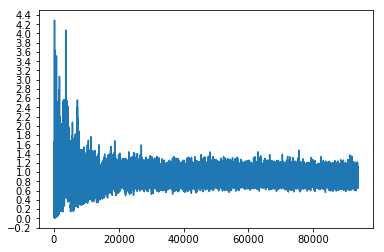

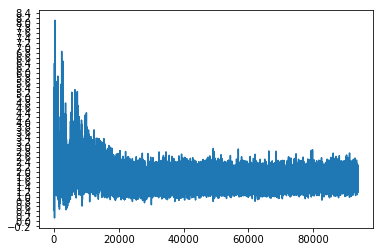

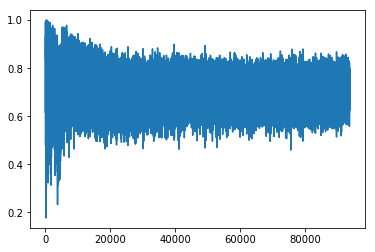

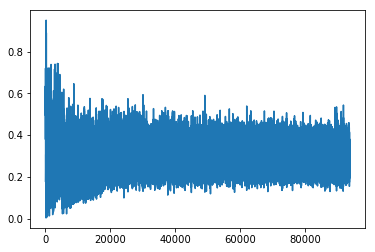

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
showPlot(d_losses)
showPlot(g_losses)
showPlot(d_xs)
showPlot(d_g_xs)